# RAG Evaluation and Meta-Evaluation with GroUSE

## Overview

This tutorial introduces GroUSE, a framework for evaluating Retrieval-Augmented Generation (RAG) pipelines, focusing on the final stage: Grounded Question Answering (GQA). It demonstrates how to use Large Language Models (LLMs) to assess GQA answers across four distinct metrics and guides you through customizing your own Judge LLM using GroUSE unit tests.

## Motivation

Manually evaluating RAG pipeline outputs can be challenging. The GroUSE framework leverages LLMs with finely tuned prompts to address all potential failure modes in Grounded Question Answering. GroUSE unit tests are used to identify the most effective prompts to optimize the performance of these evaluators.

## Key Components

1. Answer Relevancy evaluation
2. Completeness evaluation
3. Faithfulness evaluation
4. Usefulness evaluation
5. Judge LLM Customization

## Method Details

### The task we want to assess: Grounded Question Answering

Grounded Question Answering (QA) is usually the last step of a RAG pipeline: given a question and a set of documents retrieved from the corpus, an LLM must generate an answer. We expect the LLM to cite which document each piece of information is coming from, as depicted below. When no precise answer is in the documents, the LLM should indicate it in its answer. In that case, if some related information is available in the documents, the LLM can add it to the answer to show the corpus is not completely off-topic with respect to the question.

### Evaluation Metrics

Each answer is evaluated according to six metrics. The fisrt four metrics are evaluated with an evaluator LLM call. Positive acceptance and negative rejection are deducted from the first four. 

#### 1. Answer Relevancy

Answer relevancy assesses the relevance of the information provided in the answer regarding the question, using a Likert scale (1 to 5).

#### 2. Completeness

Completeness uses a Likert scale (1 to 5) to evaluate whether all relevant information from the documents is present in the answer.

#### 3. Faithfulness

Faithfulness is a binary score that checks if all facts in the answer are accurate and correctly attributed to the corresponding document.

#### 4. Usefulness

When the answer states that no references can answer the question but additional information is provided, usefulness is a binary score that determines if the provided additional information is still useful.

#### 5. Positive Acceptance

Percentage of samples that responded when they were supposed to.

#### 6. Negative Rejection

Percentage of samples that refrained from responding when there is no context in the documents that allow to answer the question.

## Benefits of the approach

The GroUSE framework comprehensively addresses the seven failure modes of Grounded Question Answering, providing a thorough evaluation of your RAG pipeline's final stage.

## Implementation details

Answer Relevancy, Completeness, Faithfulness and Usefulness are evaluated using GPT-4 as the default model, as it was the best model we tested.
Positive acceptance and negative rejection can be deducted from the answer relevancy and completeness results as these can have `None` values when no references contain answers to the question.

## Conclusion

The GroUSE framework provides a comprehensive set of evaluation metrics to assess the performance of Grounded Question Answering models. By addressing seven key failure modes, it enables developers to thoroughly evaluate and improve their RAG pipelines. The use of LLM-based judges, such as GPT-4, automate this evaluation process. To tailor the framework to your specific needs, you can develop a custom LLM evaluator and validate its performance using GroUSE unit tests.


<div style="text-align: center;">

<img src="../images/grouse.svg" alt="grouse" style="width:100%; height:auto;">
</div>

<!-- TODO add Mermaid schema -->

## Tutorial

### Import libraries

In [5]:
import os

import nest_asyncio

from grouse import (
    EvaluationSample,
    GroundedQAEvaluator,
    meta_evaluate_pipeline,
)

### Avoid nested asyncio loops inside notebooks (this line is not needed if you run the code in a Python script)

In [6]:
nest_asyncio.apply()

### Setup your API key

For this tutorial, you will need access to the OpenAI API and get an OpenAI API key. You can get one [here](https://platform.openai.com/api-keys).

In [7]:
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Initialize the evaluator

The default model used is [GPT-4](https://platform.openai.com/docs/models/gpt-4-turbo-and-gpt-4). Prompts are adapted to this model, so if you want to have the best results, keep using the default model.

In [8]:
evaluator = GroundedQAEvaluator()

### Evaluate a good answer

An LLM has given a good answer to a question related to the Eiffel Tower, given some contexts from the [Eiffel Tower Wikipedia](https://en.wikipedia.org/wiki/Eiffel_Tower) page. Let's evaluate the answer and check that everything is okay.

In [36]:
good_sample = EvaluationSample(
    input="Where is the Eiffel Tower located?",
    actual_output="The Eiffel Tower stands in the Champs de Mars in Paris.[1]",
    expected_output="In the Champs de Mars in Paris. [1]",
    references=[
        "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France"
    ]
)

result = evaluator.evaluate(eval_samples=[good_sample]).evaluations[0]

print("Answer Relevancy (1 to 5):", result.answer_relevancy.answer_relevancy)
print("Answer Relevancy (1 to 5):", result.answer_relevancy.answer_relevancy_justification)
print("Completeness (1 to 5):", result.completeness.completeness)
print("Completeness (1 to 5):", result.completeness.completeness_justification)
print("Faithfulness (0 or 1):", result.faithfulness.faithfulness)
print("Faithfulness (0 or 1):", result.faithfulness.faithfulness_justification)

100%|██████████| 1/1 [00:00<00:00, 163.53it/s]

2025-04-26 10:04:36,799 - LLM Call Tracker - INFO - Cost: 1.3518$
2025-04-26 10:04:36,799 - LLM Call Tracker - INFO - Cost: 1.3518$
2025-04-26 10:04:36,799 - LLM Call Tracker - INFO - Cost: 1.3518$
Answer Relevancy (1 to 5): 5
Answer Relevancy (1 to 5): The answer directly responds to the user's question about the location of the Eiffel Tower.
Completeness (1 to 5): 5
Completeness (1 to 5): The answer includes all the relevant information from the reference, which is the location of the Eiffel Tower.
Faithfulness (0 or 1): 1
Faithfulness (0 or 1): The sentence in the answer correctly cites its source, the information provided is in agreement with the cited source, and it does not distort or modify the content of the reference.



/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [47]:
def display_evaluation_results(result):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Extract scores and justifications from result
    scores = {
        'Answer Relevancy': result.answer_relevancy.answer_relevancy,
        'Completeness': result.completeness.completeness,
        'Faithfulness': result.faithfulness.faithfulness
    }
    justifications = {
        'Answer Relevancy': result.answer_relevancy.answer_relevancy_justification,
        'Completeness': result.completeness.completeness_justification,
        'Faithfulness': result.faithfulness.faithfulness_justification
    }

    # Create DataFrame
    results_df = pd.DataFrame({
        'Metric': list(scores.keys()),
        'Score': list(scores.values()),
        'Justification': list(justifications.values())
    })


    # Show full justification text
    pd.set_option('display.max_colwidth', None)
    print("\nEvaluation Results Table:")
    styled_df = results_df.style.set_properties(**{'text-align': 'left'})
    display(styled_df)
    

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(scores.keys(), scores.values(), color='skyblue', width=0.6)

    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.2f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Horizontal grid lines at each integer score
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yticks(range(0, 6), fontsize=12)
    plt.xticks(rotation=0, fontsize=12)  # Horizontal metric names

    plt.ylim(0, 5.5)
    plt.title('Evaluation Metrics Scores', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Score (1-5 scale)', fontsize=12)

    # Add score descriptions at the bottom, horizontally
    plt.figtext(0.5, -0.08,
                "Score Descriptions:  "
                "Answer Relevancy = How well the answer matches the question;  "
                "Completeness = How comprehensive the answer is;  "
                "Faithfulness = How accurately the answer reflects the source material.",
                ha='center', fontsize=11, style='italic', wrap=True)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for bottom text
    plt.show()


Evaluation Results Table:


,Metric,Score,Justification
0,Answer Relevancy,5,The answer directly responds to the user's question about the location of the Eiffel Tower.
1,Completeness,5,"The answer includes all the relevant information from the reference, which is the location of the Eiffel Tower."
2,Faithfulness,1,"The sentence in the answer correctly cites its source, the information provided is in agreement with the cited source, and it does not distort or modify the content of the reference."


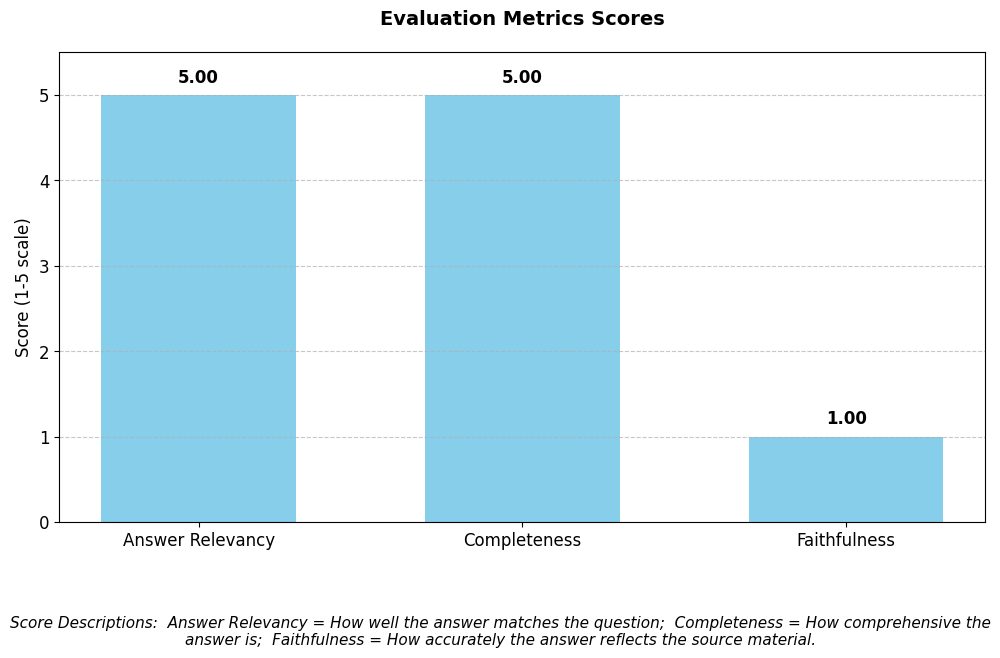

In [48]:
display_evaluation_results(result)

### How does it behave with an irrelevant answer?

In [31]:
irrelevant_sample = EvaluationSample(
    input="Where is the Eiffel Tower located?",
    actual_output="The Eiffel Tower is mainly made of puddle iron.[2]",
    expected_output="In the Champs de Mars in Paris.[1]",
    references=[
        "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France",
        "The puddle iron (wrought iron) of the Eiffel Tower weighs 7,300 tonnes,[70] and the addition of lifts, shops and antennae have brought the total weight to approximately 10,100 tonnes."
    ]
)

result = evaluator.evaluate(eval_samples=[irrelevant_sample]).evaluations[0]

print("Answer Relevancy (1 to 5):", result.answer_relevancy.answer_relevancy)
print("Justification:", result.answer_relevancy.answer_relevancy_justification)

100%|██████████| 1/1 [00:00<00:00, 201.46it/s]

2025-04-26 10:01:37,885 - LLM Call Tracker - INFO - Cost: 1.2537$
2025-04-26 10:01:37,885 - LLM Call Tracker - INFO - Cost: 1.2537$
2025-04-26 10:01:37,885 - LLM Call Tracker - INFO - Cost: 1.2537$
Answer Relevancy (1 to 5): 1
Justification: The answer provides information about the material of the Eiffel Tower, which is not relevant to the user's question about its location.



/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Evaluation of an incomplete sample

In [11]:
incomplete_sample = EvaluationSample(
    input="Who critized the Eiffel Tower project in 1889?",
    actual_output=(
        "The tower was critized by those who did not believe it was feasible and some artists.[1]"
    ),
    expected_output=(
        "The tower was critized by those who did not believe it was feasible and those who objected on artistic grounds.[1]"
        "An artist committee was created to protest againt the construction of the tower, led by the prominent architect "
        "Charles Garnier and including some of the most important figures of the arts, "
        "such as William-Adolphe Bouguereau, Guy de Maupassant, Charles Gounod and Jules Massenet. [2]"
    ),
    references=[
        "The proposed tower had been a subject of controversy, drawing criticism from those who did not believe it was feasible and those who objected on artistic grounds.",
        (
            "It came to a head as work began at the Champ de Mars: a \"Committee of Three Hundred\" "
            "(one member for each metre of the tower's height) was formed, led by the prominent architect "
            "Charles Garnier and including some of the most important figures of the arts, "
            "such as William-Adolphe Bouguereau, Guy de Maupassant, Charles Gounod and Jules Massenet."
        ),
        "A petition called \"Artists against the Eiffel Tower\" was sent to the Minister of Works and Commissioner for the Exposition, Adolphe Alphand, and it was published by Le Temps on 14 February 1887"
    ]
)

result = evaluator.evaluate(eval_samples=[incomplete_sample]).evaluations[0]

print("Completeness (1 to 5):", result.completeness.completeness)
print("Justification:", result.completeness.completeness_justification)

100%|██████████| 1/1 [00:24<00:00, 24.49s/it]

2025-04-26 09:28:56,243 - LLM Call Tracker - INFO - Cost: 0.3269$
Completeness (1 to 5): 2
Justification: This answer only includes part of the relevant information from the references. It mentions the criticism from those who did not believe the project was feasible and some artists. However, it does not mention the formation of the artist committee, the leader of the committee, or the names of the important figures of the arts who were part of the committee.


### Evaluation of an unfaithful sample

In [12]:
unfaithful_sample = EvaluationSample(
    input="Where is the Eiffel Tower located?",
    actual_output="The Eiffel Tower is located at Rue Rabelais in Paris.[1][2]",
    expected_output="In the Champs de Mars in Paris.[1]",
    references=[
        "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France",
        "Gustave Eiffel died in his appartment at Rue Rabelais in Paris."
    ]
)

result = evaluator.evaluate(eval_samples=[unfaithful_sample]).evaluations[0]

print("Faithfulness (0 or 1):", result.faithfulness.faithfulness)
print("Justification:", result.faithfulness.faithfulness_justification)

100%|██████████| 1/1 [00:18<00:00, 18.61s/it]

2025-04-26 09:29:14,867 - LLM Call Tracker - INFO - Cost: 0.4289$
Faithfulness (0 or 1): 0
Justification: The sentence in the answer cites its sources, but the information provided is not in agreement with the cited sources. The Eiffel Tower is not located at Rue Rabelais in Paris.


### Evaluation of information utility in case there is no answer to the question in the references

In [13]:
useful_sample = EvaluationSample(
    input="Who critized the Eiffel Tower project in 1889?",
    actual_output=(
        "No document seems to precisely answer your question."
        "However, it is mentioned that a petition against tht Eiffel Tower construciton was sent "
        "to the Minister of Works and Commissioner for the Exposition [1]"
    ),
    expected_output=(
        "No document seems to precisely answer your question."
        "However, it is worth noting that a petition against tht Eiffel Tower construciton was sent "
        "to the Minister of Works and Commissioner for the Exposition [1]"
    ),
    references=[
        "A petition against the tower was sent to the Minister of Works and Commissioner for the Exposition, Adolphe Alphand, and it was published by Le Temps on 14 February 1887"
    ]
)

result = evaluator.evaluate(eval_samples=[useful_sample]).evaluations[0]

print("Usefulness (0 or 1):", result.usefulness.usefulness)
print("Justification:", result.usefulness.usefulness_justification)
print("Positive Acceptance:", result.positive_acceptance)
print("Negative Rejection:", result.negative_rejection)

100%|██████████| 1/1 [00:31<00:00, 31.52s/it]

2025-04-26 09:29:46,392 - LLM Call Tracker - INFO - Cost: 0.5763$
Usefulness (0 or 1): 1
Justification: The related information provided is directly linked to the user's question. It does not name the critics of the Eiffel Tower project in 1889, but it does mention a petition against the project, which implies criticism.
Positive Acceptance: 1
Negative Rejection: 1


### Note that all the results are cached and we can compute the global statistics on all the samples

In [14]:
evaluation_report = evaluator.evaluate(eval_samples=[
    good_sample,
    irrelevant_sample,
    incomplete_sample,
    unfaithful_sample,
    useful_sample,
]).report
print("Average answer relevancy: ", evaluation_report.answer_relevancy)
print("Average completeness: ", evaluation_report.completeness)
print("Average faithfulness: ", evaluation_report.faithfulness)
print("Average usefulness: ", evaluation_report.usefulness)

100%|██████████| 5/5 [00:00<00:00, 133.11it/s]

2025-04-26 09:29:46,435 - LLM Call Tracker - INFO - Cost: 1.1526$
Average answer relevancy:  3.0
Average completeness:  2.25
Average faithfulness:  0.8
Average usefulness:  1.0


## Create your own Judge LLM

Since GPT-4 is expensive, let's create a new evaluator using gpt-4o-mini. For that, we need to adapt the evaluation prompt to the model by using the train set of the [GroUSE unit tests](https://huggingface.co/datasets/illuin/grouse).
Make sure that the output follows the same format as described in the prompts below.

### Answer Relevancy prompt

In [15]:
relevancy_evaluation_prompt = """# Task

Task: Grounded Question Answering
Based solely on the content of the references, the objective is to generate a response to the user's query. Each statement must be followed by the reference of the source passage, in the format [i] where i is the number of the reference. If no passage seems relevant, the answer should begin with "No document seems to precisely answer your question" and may be supplemented with related sourced information.

# Instructions

I will provide you with two answers, numbered 1 and 2, each containing a response to the user request.
I want you to assign to each answer a relevancy grade between 1 and 5:
- Answer relevancy evaluates if the content of the answer accurately responds to the user's question.
- The truthfulness of the information in the answer does not impact relevancy: even if information that appears false is contained in the answer, as long as this information is related to the request, then relevancy should not decrease. Remember that this information could come from references mentioning imaginary content that you are unaware of: the only thing to evaluate to assign the relevancy grade is therefore the adequacy between the information in the answer and the request, NOT their truthfulness.
- The absence of information in the answer does not impact relevancy, only the information contained in the answer is evaluated.
- Answer relevancy cannot be evaluated if the answer mentions that no document responds to the user request, it is then `null`, regardless of whether it contains other information or not.

Rating scale:
null - The answer asserts that no document precisely responds to the user request. Even if it provides additional information, whether appropriate or not, the relevancy remains `null`.
5 - The answer has excellent relevancy. All information provided in the answer is in line with the question and precisely answers the user request.
4 - The answer achieves good relevancy by providing relevant information to answer the user question. Some information indicated does not exactly answer the question, but remains in line with the request.
3 - The answer has average relevancy, it contains information that allows responding to the user request, but it also contains superfluous information, which was not necessary to answer the request.
2 - The answer shows low relevancy, with some elements related to the request, but the majority of the content is not in line with the question asked.
1 - The answer has very low relevancy, not answering the user's question at all. The content is largely inappropriate or off-topic, delivering no useful information for the request.

Before assigning each grade, you will check that the answer does not contain "No document responds...", if this is the case you must put a grade of `null`. If this is not the case, you will then analyze the adequacy between the request and the information contained in the answer.
Your response should be in JSON format, respecting the following format:
{
    "answer_1": {
        "answer_affirms_no_document_answers": X,
        "answer_relevancy_justification": "...",
        "answer_relevancy": Y
    },
    "answer_2": {
        "answer_affirms_no_document_answers": X,
        "answer_relevancy_justification": "...",
        "answer_relevancy": Y
    }
}
Where "..." is a string, X is a boolean, and Y is an integer between 1 and 5 or `null`.

# Sample

User request: {{ input }}

# To evaluate

Answer 1: {{ expected_output }}
Answer 2: {{ actual_output }}"""

### Completeness prompt

In [16]:
completeness_evaluation_prompt = """# Task

Task: Grounded Question Answering
Based solely on the content of the references, the objective is to generate a response to the user's query. Each statement must be followed by the reference of the source passage, in the format [i] where i is the number of the reference. If no passage seems relevant, the answer should begin with "No document seems to precisely answer your question" and may be supplemented with related sourced information.

# Instructions

I will provide you with two answers, numbered 1 and 2, each containing a response to the user request.
I want you to assign to each answer a completeness grade between 1 and 5:
- The only condition for an answer to be complete is the presence in it of at least all the information from the references that are relevant to the question asked.
- The presence of unrelated information in the answer does not impact completeness.
- The presence of information in the answer not from the references does not impact completeness.
- Possible errors in the sources citing the references do not impact completeness.
- Completeness cannot be evaluated if the references contain no information that can precisely answer the user request, in which case the grade takes the value `null`.

Rating scale:
null - The references contained no relevant information to precisely answer the user's question. In this case, there is no need to read the content of the answer to know that the grade is `null`.
5 - The answer is very complete, it contains all the relevant information from the references. No essential information is omitted, ensuring complete coverage of the question asked.
4 - The answer covers most of the relevant information in depth. It integrates the references satisfactorily, covering the majority of key points. Some details may be missing, but overall, the answer is substantial.
3 - The answer reasonably addresses a number of relevant aspects. It integrates part of the necessary information from the references. However, gaps remain, impacting the overall completeness.
2 - The answer only covers a minimal part of the relevant information. It misses several important information from the references.
1 - The answer covers none of the relevant information, all relevant information from the references has been omitted in the answer.

Before assigning each grade, you will always start by analyzing the information found in the references that are relevant to the user request. If there is no relevant information in the references, completeness must be `null`. If there are relevant information in the references, you will analyze which portion of this information is present or absent in the answers to evaluate the completeness grade. Your response should be in JSON format, respecting the following format:
{
    "answer_1": {
        "completeness_justification": "...",
        "completeness": X
    },
    "answer_2": {
        "completeness_justification": "...",
        "completeness": X
    }
}
Where "..." is a string, and X is an integer between 1 and 5 or `null`.

# SAMPLE

List of references :
{%- for context in contexts %}
Reference {{ loop.index }}: {{ context }}
{%- endfor %}
User request: {{ input }}

# To evaluate

Answer 1: {{ expected_output }}
Answer 2: {{ actual_output }}"""

### Faithfulness prompt

In [17]:
faithfulness_evaluation_prompt = """# Task

Task: Grounded Question Answering
Based solely on the content of the references, the objective is to generate a response to the user's query. Each statement must be followed by the reference of the source passage, in the format [i] where i is the number of the reference. If no passage seems relevant, the answer should begin with "No document seems to precisely answer your question" and may be supplemented with related sourced information.

# Instructions

I will provide you with two answers, numbered 1 and 2, each containing a response to the user request.
I want you to assign to each answer a boolean faithfulness grade. An answer is faithful if:
- Each statement made by the answer is followed by a source indicating the reference from which it is drawn.
- The information preceding the source is indeed from the corresponding reference.
- The information preceding the source is in agreement with the corresponding reference, and does not assert facts different from those indicated in the reference.
In all other cases, the response is considered non-faithful.
Faithfulness is also considered non-measurable if the answer asserts that no document responds to the question, and it does not provide any related information, it is then `null`.

Rating scale:
null - The answer asserts that no document responds to the question, and does not provide any related information.
1 - All sentences in the answer cite their sources, and are in agreement with the cited sources.
0 - At least one sentence in the response does not cite its sources, or cites a wrong source, or modifies the content from the references, or asserts something that is not supported by the cited references.

Before assigning each grade, you will start by verifying that the answer does not only assert "No document responds...", without any other information. If this is the case, then faithfulness must be `null`. Otherwise, I want you to analyze by explaining for each sentence, one after the other, if 1) a reference follows the sentence, 2) the reference following the sentence is correct, and 3) if the sentence does not distort or modify the content of the references. Your response should be in JSON format, respecting the following format:
{
    "answer_1": {
        "answer_only_asserts_no_document_answers": X,
        "content_analysis_sentence_by_sentence": [
            {
                "sentence": "...",
                "criterion_1": "...",
                "criterion_2": "...",
                "criterion_3": "..."
            },
            ...
        ],
        "faithfulness_justification": "...",
        "faithfulness": Y
    },
    "answer_2": {
        "answer_only_asserts_no_document_answers": X,
        "content_analysis_sentence_by_sentence": [
            {
            "sentence": "...",
            "criterion_1": "...",
            "criterion_2": "...",
            "criterion_3": "..."
            },
            ...
        ],
        "faithfulness_justification": "...",
        "faithfulness": Y
    }
}
Where "..." is a string, X is a boolean, and Y is either a boolean or `null`.

# Sample

List of references :
{%- for context in contexts %}
Reference {{ loop.index }}: {{ context }}
{%- endfor %}

# To evaluate

Answer 1: {{ expected_output }}
Answer 2: {{ actual_output }}"""

### Usefulness Prompt

In [18]:
usefulness_evaluation_prompt = """# Task

Task: Grounded Question Answering
Based solely on the content of the references, the objective is to generate a response to the user's query. Each statement must be followed by the reference of the source passage, in the format [i] where i is the number of the reference. If no passage seems relevant, the answer should begin with "No document seems to precisely answer your question" and may be supplemented with related sourced information.

# Instructions

I will provide you with two answers, numbered 1 and 2, each containing a response to the user request.
I want you to assign to each answer a usefulness grade of 0 or 1:
- Usefulness is only evaluated when the answer says that no document precisely answers the user's question, but it still provides information related to the question.
- Usefulness measures how interesting the related information is to know for the user, given that there is no answer in the references.
- If the answer responds to the user request, usefulness must be `null`.
- If the answer indicates that no document responds to the user request, without adding other information, usefulness must be `null`.

Rating scale:
null - (The answer responds to the user request) OR (the answer does not answer the user's question AND does not provide any related information).
1 - The related information is generally related to the question and adds value to the general understanding of the topic.
0 - The related information is completely off-topic with respect to the question asked.

Before assigning each grade, you will start by verifying that the answer indeed asserts "No document responds...", then you will check that the answer contains related information in addition to this assertion. If one of these two conditions is `false` then usefulness must be `null`.
If both conditions are indeed true, then you will analyze the usefulness of having added this related information to evaluate the usefulness grade. Your response should be in JSON format, respecting the following format:
{
    "answer_1": {
        "answer_affirms_no_document_answers": X,
        "answer_contains_related_information": X,
        "usefulness_justification": "...",
        "usefulness": Y
    },
    "answer_2": {
        "answer_affirms_no_document_answers": X,
        "answer_contains_related_information": X,
        "usefulness_justification": "...",
        "usefulness": Y
    }
}
Where "..." is a string, X is a boolean, and Y is an integer that is 0 or 1 or `null`.

# Sample

User request: {{ input }}

# To evaluate

Answer 1: {{ expected_output }}
Answer 2: {{ actual_output }}"""

### Save prompts to use them later

In [19]:
prompts_path = "gpt4o_mini_prompts"
os.makedirs(prompts_path, exist_ok=True)

with open(os.path.join(prompts_path, "answer_relevancy.txt.jinja"), "w") as file:
    file.write(relevancy_evaluation_prompt)
with open(os.path.join(prompts_path, "completeness.txt.jinja"), "w") as file:
    file.write(completeness_evaluation_prompt)
with open(os.path.join(prompts_path, "faithfulness.txt.jinja"), "w") as file:
    file.write(faithfulness_evaluation_prompt)
with open(os.path.join(prompts_path, "usefulness.txt.jinja"), "w") as file:
    file.write(usefulness_evaluation_prompt)


### Check results on train set

In [20]:
meta_evaluations = meta_evaluate_pipeline("gpt-4o-mini", prompts_path, train_set=True)
print("Aggregated metrics")
print(meta_evaluations.report)

Generating train split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/144 [00:00<?, ? examples/s]

100%|██████████| 16/16 [00:26<00:00,  1.63s/it]

2025-04-26 09:30:19,985 - LLM Call Tracker - INFO - Cost: 0.0148$
2025-04-26 09:30:19,985 - LLM Call Tracker - INFO - Cost: 0.0148$
Aggregated metrics
answer_relevancy_success=1.0 completeness_success=0.75 faithfulness_success=0.625 usefulness_success=0.9375 positive_acceptance_success=0.8125 negative_rejection_success=0.75 total=0.8125


It is an encouraging beginning. But, we can iterate on the prompts above to try to have better scores with GPT-4o-mini. Still, it will be difficult to have a performance as good as GPT-4.

### Once you are happy with your prompts, you can evaluate the Judge model on the test set

In [21]:
meta_evaluations = meta_evaluate_pipeline("gpt-4o-mini", prompts_path, train_set=False)
meta_evaluations.report

 65%|██████▍   | 93/144 [01:43<01:12,  1.43s/it]


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



RateLimitError: litellm.RateLimitError: RateLimitError: OpenAIException - Rate limit reached for gpt-4o-mini in organization org-JV6yPaNcUy5jq93eBhjTM7ed on tokens per min (TPM): Limit 200000, Used 199578, Requested 2218. Please try again in 538ms. Visit https://platform.openai.com/account/rate-limits to learn more.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.I

## Limitations

Unit tests can help you assess the limits of your judge LLM on edge cases but don't guarantee that your judge LLM will be perfect. Be cautious when analysing the results.

## References

```latex
@misc{muller2024grousebenchmarkevaluateevaluators,
      title={GroUSE: A Benchmark to Evaluate Evaluators in Grounded Question Answering}, 
      author={Sacha Muller and António Loison and Bilel Omrani and Gautier Viaud},
      year={2024},
      eprint={2409.06595},
      archivePrefix={arXiv},
      primaryClass={cs.CL},
      url={https://arxiv.org/abs/2409.06595}, 
}
```